**Data Mining Project, midterm 2021/2022**

**Authors:** Niko Dalla Noce, Alessandro Ristori, Giuseppe Lombardi

# **Task 2 Predictive Analysis**

## **Import the libraries and load the player dataset**

First we have to import the necessary libraries to work within our project.

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sn
import math
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA

The dataset coming from the data preparation task is saved on github.

In [123]:
!git clone 'https://github.com/nikodallanoce/DataMiningProject/'

fatal: destination path 'DataMiningProject' already exists and is not an empty directory.


**Load the players' profile dataset**

In [124]:
df_players = pd.read_parquet('/content/DataMiningProject/DM_14_TASK2/players_dataset.gzip')
df_players

,name,sex,age,ioc,ht,hand,t_won,p_wins,wins,p_w_Hard,w_Hard,p_w_Clay,w_Clay,p_w_Grass,w_Grass,p_aces,p_double_faults,p_1st_in,mean_1st_in,p_1st_won,mean_1st_won,p_2nd_won,mean_2nd_won,mean_sv_points,p_bp_saved,mean_bp_saved,mean_bp_faced,rank,rank_points,age_range,ht_range,rank_range
0,alexander zverev,M,24,DEU,198,R,16,70.08,260,68.44,154,74.77,83,65.71,23,10.72,5.40,64.78,52,74.55,39,49.86,14,81,60.90,3,5,5,7263,"[21,27]",>190,top 10
8,frank moser,M,40,DEU,193,R,0,45.45,5,50.00,3,50.00,1,33.33,1,7.70,2.82,57.00,40,72.97,29,47.16,14,70,68.83,4,7,848,19,>34,>190,top 1000
13,ruben ramirez hidalgo,M,41,ESP,183,R,0,52.27,46,57.89,11,50.72,35,0.00,0,5.37,5.03,57.46,39,69.42,27,48.31,14,69,61.38,4,7,341,142,>34,"[181,190]",top 500
14,tommy haas,M,39,DEU,188,R,0,30.00,6,0.00,0,33.33,4,40.00,2,5.56,4.80,61.23,52,68.67,35,53.85,17,85,68.52,5,8,248,205,>34,"[181,190]",top 250
15,toshihide matsui,M,41,JPN,180,R,0,37.74,20,38.78,19,25.00,1,0.00,0,8.89,5.72,58.14,36,70.63,25,49.53,12,61,61.29,3,5,752,21,>34,"[171,180]",top 1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,alexandar lazov,M,29,BGR,182,U,0,53.12,17,33.33,3,60.87,14,0.00,0,6.35,5.62,61.90,39,67.88,26,48.08,11,63,61.04,4,7,828,16,"[28,34]","[181,190]",top 1000
4254,david o hare,M,27,IRL,184,U,0,26.67,4,23.08,3,0.00,0,50.00,1,8.04,9.07,61.40,43,70.32,30,44.07,12,71,62.75,4,6,2221,0,"[21,27]","[181,190]",top 1000
4255,kuan-yi lee,M,23,TWN,173,R,0,47.06,16,48.48,16,0.00,0,0.00,0,4.40,3.13,67.87,42,65.75,28,49.78,10,62,58.59,3,6,573,42,"[21,27]","[171,180]",top 1000
4256,ben patael,M,22,ISR,192,U,0,41.03,16,45.45,10,35.29,6,0.00,0,6.63,4.40,61.33,41,65.82,27,48.92,12,67,56.25,3,6,562,45,"[21,27]",>190,top 1000


In [125]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 0 to 4257
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             1600 non-null   object  
 1   sex              1600 non-null   object  
 2   age              1600 non-null   Int32   
 3   ioc              1600 non-null   object  
 4   ht               1600 non-null   Int32   
 5   hand             1600 non-null   object  
 6   t_won            1600 non-null   Int32   
 7   p_wins           1600 non-null   float64 
 8   wins             1600 non-null   Int32   
 9   p_w_Hard         1600 non-null   float64 
 10  w_Hard           1600 non-null   Int32   
 11  p_w_Clay         1600 non-null   float64 
 12  w_Clay           1600 non-null   Int32   
 13  p_w_Grass        1600 non-null   float64 
 14  w_Grass          1600 non-null   Int32   
 15  p_aces           1600 non-null   float64 
 16  p_double_faults  1600 non-null   float64 


## **Data Labelling**

**Compute the label for any customer**

In [126]:
df_label = df_players[['p_wins', 'wins','rank', 'rank_points']]

In [127]:
scaler = StandardScaler()  # z-score scaler

x_scaled = scaler.fit_transform(df_label.values)
df_label_scaled = pd.DataFrame(x_scaled, columns=df_label.columns, index=df_label.index)

df_label_scaled

,p_wins,wins,rank,rank_points
0,2.014899,3.878259,-1.130862,7.417577
8,0.084832,-0.836725,1.012741,-0.440268
13,0.619264,-0.078629,-0.276472,-0.306845
14,-1.125868,-0.818235,-0.512955,-0.238507
15,-0.519343,-0.559373,0.768630,-0.438099
...,...,...,...,...
4253,0.685872,-0.614843,0.961885,-0.443522
4254,-1.386815,-0.855215,4.504044,-0.460878
4255,0.210995,-0.633333,0.313464,-0.415319
4256,-0.261530,-0.633333,0.285493,-0.412065


In [128]:
k = 2
kmeans = KMeans(n_clusters=k, n_init=100)
kmeans.fit(x_scaled)

KMeans(n_clusters=2, n_init=100)

Let's see how many players are in each cluster.

In [129]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
clust_dict = dict(zip(bins, hist))
print(clust_dict)

{0: 557, 1: 1043}


We now plot the clusters using the PCA.

Text(255    7.500884
Name: PC_1, dtype: float64, 255    8.152789
Name: PC_2, dtype: float64, 'novak djokovic')

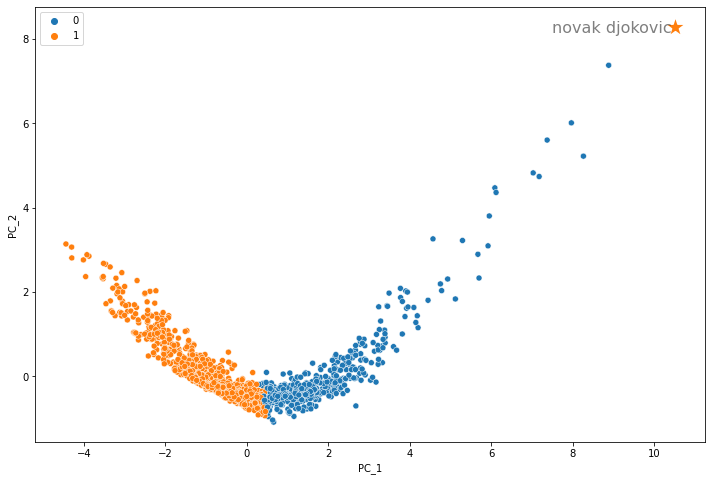

In [130]:
pca = PCA(n_components=2) 
data_to_visualize = pd.DataFrame(pca.fit_transform(x_scaled), columns=['PC_1','PC_2'], index=df_label.index)
data_to_visualize['cluster'] = pd.Categorical(kmeans.labels_)
plt.figure(figsize=(12,8))
sn.scatterplot(x="PC_1",y="PC_2", hue="cluster", data=data_to_visualize);

name = 'novak djokovic'  # we took the player with the most tourneys won as an example
index = df_label[df_players['name'] == name].index
a = data_to_visualize.loc[index, 'PC_1']
b = data_to_visualize.loc[index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
plt.text(x=a-3, y=b-0.14, s=name, fontdict=dict(color='black', alpha=0.5, size=16))

In [131]:
def plot_basic_statistics(df, labels, columns):
    df_plot = pd.DataFrame(df, columns=columns, copy=True)
    df_plot['cluster'] = labels
    columns = df_plot.columns[0:-1]     
    means = []
    std = []
    label_s = 12
    fig = plt.figure(figsize=(14,8))
    for i in np.unique(df_plot['cluster'].array):
        clust = df.loc[df_plot['cluster'] == i, columns]
        means.append(clust.describe().loc['mean'].values)
        std.append(clust.describe().loc['std'].values)  
    legend = []
    for i in np.unique(df_plot['cluster'].array):
        plt.plot(range(0, columns.shape[0]), means[i], marker='o')
        legend.append('Cluster %d' %i)
    plt.legend(legend)
    plt.xticks(range(0, columns.shape[0]), columns, fontsize=label_s, rotation=55)

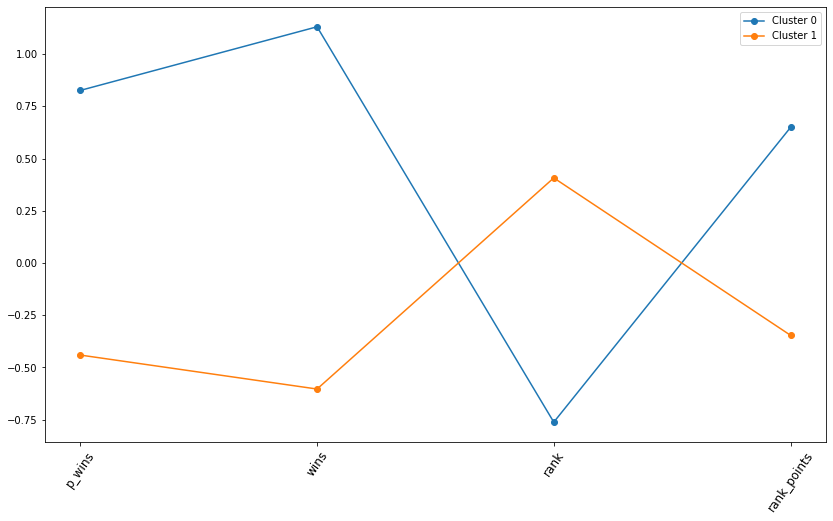

In [132]:
label_players = kmeans.labels_
plot_basic_statistics(df_label_scaled, label_players, df_label_scaled.columns)

From what we can see, cluster 1 contains the strong players, meanwhile cluster 0 contains weak players.

<Figure size 1368x360 with 0 Axes>

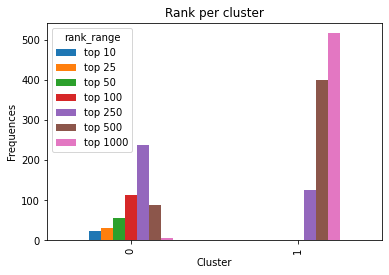

In [133]:
fig = plt.figure(figsize=(19, 5));

label_players = kmeans.labels_

rank_xt_pct = pd.crosstab(label_players, df_players['rank_range'])
rank_xt_pct.plot(kind='bar', stacked=False, title='Rank per cluster', xlabel="Cluster", ylabel="Frequences")

**Labelling the players**: target 0 represents weak player, target 1 represents strong player.

In [134]:
label_players = kmeans.labels_
df_players['target'] = label_players

df_players

,name,sex,age,ioc,ht,hand,t_won,p_wins,wins,p_w_Hard,w_Hard,p_w_Clay,w_Clay,p_w_Grass,w_Grass,p_aces,p_double_faults,p_1st_in,mean_1st_in,p_1st_won,mean_1st_won,p_2nd_won,mean_2nd_won,mean_sv_points,p_bp_saved,mean_bp_saved,mean_bp_faced,rank,rank_points,age_range,ht_range,rank_range,target
0,alexander zverev,M,24,DEU,198,R,16,70.08,260,68.44,154,74.77,83,65.71,23,10.72,5.40,64.78,52,74.55,39,49.86,14,81,60.90,3,5,5,7263,"[21,27]",>190,top 10,0
8,frank moser,M,40,DEU,193,R,0,45.45,5,50.00,3,50.00,1,33.33,1,7.70,2.82,57.00,40,72.97,29,47.16,14,70,68.83,4,7,848,19,>34,>190,top 1000,1
13,ruben ramirez hidalgo,M,41,ESP,183,R,0,52.27,46,57.89,11,50.72,35,0.00,0,5.37,5.03,57.46,39,69.42,27,48.31,14,69,61.38,4,7,341,142,>34,"[181,190]",top 500,1
14,tommy haas,M,39,DEU,188,R,0,30.00,6,0.00,0,33.33,4,40.00,2,5.56,4.80,61.23,52,68.67,35,53.85,17,85,68.52,5,8,248,205,>34,"[181,190]",top 250,1
15,toshihide matsui,M,41,JPN,180,R,0,37.74,20,38.78,19,25.00,1,0.00,0,8.89,5.72,58.14,36,70.63,25,49.53,12,61,61.29,3,5,752,21,>34,"[171,180]",top 1000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,alexandar lazov,M,29,BGR,182,U,0,53.12,17,33.33,3,60.87,14,0.00,0,6.35,5.62,61.90,39,67.88,26,48.08,11,63,61.04,4,7,828,16,"[28,34]","[181,190]",top 1000,1
4254,david o hare,M,27,IRL,184,U,0,26.67,4,23.08,3,0.00,0,50.00,1,8.04,9.07,61.40,43,70.32,30,44.07,12,71,62.75,4,6,2221,0,"[21,27]","[181,190]",top 1000,1
4255,kuan-yi lee,M,23,TWN,173,R,0,47.06,16,48.48,16,0.00,0,0.00,0,4.40,3.13,67.87,42,65.75,28,49.78,10,62,58.59,3,6,573,42,"[21,27]","[171,180]",top 1000,1
4256,ben patael,M,22,ISR,192,U,0,41.03,16,45.45,10,35.29,6,0.00,0,6.63,4.40,61.33,41,65.82,27,48.92,12,67,56.25,3,6,562,45,"[21,27]",>190,top 1000,1


## **Classification**

### **Discretize the categorical variables**


We can discretize the categorical variables and then use them for the classification task. NB: for some classifiers it may not be a good practice (example: classifiers which use distance metrics for the classifications, such as KNN)


In [135]:
def discretize_data(dataset, variables):
    '''
    Function to discretize the variables
    
        input: the dataset and the list of variables' names to discretize
    '''
    for variable in variables:
        # get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        # generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        # add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [136]:
# discretize the variable relationship, sex, occupation, marital-status, native-country, race
variables = ['name', 'sex', 'ioc', 'hand']
df_class = discretize_data(df_players, variables)

# drop the categorical variables since we don't need them anymore 
df_class.drop(columns=['name', 'sex', 'ioc', 'hand', 	'age_range',	'ht_range',	'rank_range'], axis=1,inplace=True)

# move 'target' column to last position
columns = df_class.columns.to_list()
columns.pop(columns.index('target'))
columns = columns + ['target']

df_class = df_class[columns]

#the resulting dataset
df_class.head()

,age,ht,t_won,p_wins,wins,p_w_Hard,w_Hard,p_w_Clay,w_Clay,p_w_Grass,w_Grass,p_aces,p_double_faults,p_1st_in,mean_1st_in,p_1st_won,mean_1st_won,p_2nd_won,mean_2nd_won,mean_sv_points,p_bp_saved,mean_bp_saved,mean_bp_faced,rank,rank_points,name_num,sex_num,ioc_num,hand_num,target
0,24,198,16,70.08,260,68.44,154,74.77,83,65.71,23,10.72,5.40,64.78,52,74.55,39,49.86,14,81,60.90,3,5,5,7263,68,1,17,1,0
8,40,193,0,45.45,5,50.00,3,50.00,1,33.33,1,7.70,2.82,57.00,40,72.97,29,47.16,14,70,68.83,4,7,848,19,528,1,17,1,1
13,41,183,0,52.27,46,57.89,11,50.72,35,0.00,0,5.37,5.03,57.46,39,69.42,27,48.31,14,69,61.38,4,7,341,142,1297,1,24,1,1
14,39,188,0,30.00,6,0.00,0,33.33,4,40.00,2,5.56,4.80,61.23,52,68.67,35,53.85,17,85,68.52,5,8,248,205,1466,1,17,1,1
15,41,180,0,37.74,20,38.78,19,25.00,1,0.00,0,8.89,5.72,58.14,36,70.63,25,49.53,12,61,61.29,3,5,752,21,1469,1,41,1,1


## **Da fare**